In [ ]:
#For colab
#%cd /content/drive/MyDrive/ML\ Project

/content/drive/MyDrive/ML Project


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.utils import save_image, make_grid
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
from skimage import metrics
import numpy as np
import librosa
import os
import glob
import cv2
from PIL import Image
import pandas as pd

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
input_dim = 104
latent_dim = 100
channels = 3
height = 256
width = 256

batch_size = 64
epochs = 100
learning_rate = 0.0625

In [ ]:
raw_df = pd.read_csv("data/dataset.csv")
in_df = raw_df[raw_df["CLASS2"] == "BEACH"]
in_df = in_df[~in_df["IMAGE"].str.contains("beach4-")]
in_df = in_df[~in_df["IMAGE"].str.contains("beach3-")]
in_df = in_df.drop(columns=["CLASS1", "CLASS2"], axis=1)

in_df = in_df.reset_index(drop=True)

in_df["image_set"] = np.select([in_df["IMAGE"].str.contains("beach/"), in_df["IMAGE"].str.contains("beach2/")],["B1", "B2"], "B2")

img_col = "IMAGE"
data_df = in_df.drop(columns=[img_col], axis=1)

print(f"Shape: {data_df.shape}")
data_df.head()

Shape: (480, 105)


,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,mfcc_96,mfcc_97,mfcc_98,mfcc_99,mfcc_100,mfcc_101,mfcc_102,mfcc_103,mfcc_104,image_set
0,15.078206,2.305278,-4.199411,-20.055079,14.721058,-30.146495,20.333356,-8.350599,-0.571023,4.979699,...,20.741725,-46.727601,32.414050,-16.763524,-8.893634,17.092140,-10.260054,14.707524,-8.256222,B1
1,15.753304,1.192929,-3.342200,-12.324450,17.318378,-33.980467,17.502614,-11.601363,-1.608385,-5.846157,...,39.535857,-43.631765,25.096030,-27.898915,-2.057907,21.801902,-15.656963,11.185660,-4.325331,B1
2,14.547205,-6.237383,-3.993959,-18.174563,2.680113,-22.080979,5.062437,-13.801832,-8.830900,-6.219190,...,16.453103,-59.641580,22.192683,-31.762745,-6.734344,8.412215,-27.442439,-0.160043,-12.274825,B1
3,13.368157,-5.270757,-3.619854,-12.980439,5.417761,-28.417257,8.232602,-17.036450,-7.979830,7.953094,...,10.895241,-53.441072,11.625694,-22.525387,-12.455758,0.815434,-23.210999,-5.381477,-9.359326,B1
4,15.029634,-0.644726,-9.139273,-21.358520,8.258333,-36.139646,19.831567,-9.693486,4.174899,8.131325,...,13.812001,-35.109134,18.114509,-18.658405,-4.433296,3.569150,-0.012868,4.792102,-3.304863,B1


In [5]:
data_df["image_set"].value_counts()

,count
image_set,
B1,240
B2,240


In [6]:
target_df = in_df[[img_col]]
print(f"Shape: {target_df.shape}")
target_df.head()

Shape: (480, 1)


,IMAGE
0,images/beach/beach0.png
1,images/beach/beach1.png
2,images/beach/beach2.png
3,images/beach/beach3.png
4,images/beach/beach4.png


In [ ]:
class SceneDataset(Dataset):
  def __init__(self, data_df, target_df, transform=None):
    self.data = data_df
    self.target_paths = target_df
    self.img_transform = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Resize((height, width)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    data = torch.tensor(self.data.iloc[idx].values, dtype=torch.float32)

    img = Image.open("data/" + self.target_paths.iloc[idx].iloc[0])
    if self.img_transform:
      img = self.img_transform(img)

    target = torch.tensor(np.array(img), dtype=torch.float32)

    return data, target

In [8]:
train_data, test_data, train_target, test_target = train_test_split(data_df.drop(columns=["image_set"], axis=1), target_df, test_size=0.25, random_state=42, stratify=data_df['image_set'])
train_dataloader = DataLoader(SceneDataset(train_data, train_target), batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(SceneDataset(test_data, test_target), batch_size=batch_size, shuffle=True)

In [9]:
for data, target in train_dataloader:
  print(data.shape)
  print(target.shape)
  break

torch.Size([64, 104])
torch.Size([64, 3, 256, 256])


In [10]:
class VAE(nn.Module):
  def __init__(self, input_dim, latent_dim=latent_dim, channels=3, height=height, width=width):
    super(VAE, self).__init__()

    #network vars
    self.input_dim = input_dim
    self.latent_dim = latent_dim
    self.channels = channels
    self.height = height
    self.width = width

    # encoder
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, 768),
        nn.LeakyReLU(0.2),
        nn.Linear(768, 512),
        nn.LeakyReLU(0.2),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, latent_dim),
        nn.LeakyReLU(0.2),
    )

    # latent mean and var
    self.mean0 = nn.Linear(latent_dim, 2)
    self.logvar0 = nn.Linear(latent_dim, 2)

    # decoder
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(8),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(8, 4, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(4),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(4, channels, kernel_size=4, stride=2, padding=1),
        nn.Tanh(),
    )

  def encode(self, x):
    x = self.encoder(x)
    return x
    #mean, logvar = self.mean0(x), self.logvar0(x)
    #return mean, logvar

  def reparameterize(self, mu, logvar):
    eps = torch.randn_like(logvar).to(device)
    return mu + eps*logvar

  def decode(self, x):
    return self.decoder(x)

  def forward(self, x):
    #mu, logvar = self.encode(x)
    #z = self.reparameterize(mu, logvar)
    #z = z.view(z.size(0), -1, 1, 1)

    x = self.encode(x)
    x = x.view(x.size(0), -1, 1, 1)
    x = self.decode(x)

    return x

In [11]:
#function to calculate similarity metrics
#Reference: https://medium.com/scrapehero/exploring-image-similarity-approaches-in-python-b8ca0a3ed5a3
#modified to accomodate tensors and batches
def calc_similarity(targets, outputs):
  hist_scores, ssim_scores = [], []

  for image1, image2 in zip(targets, outputs):
    image1 = image1.permute(1, 2, 0).cpu().numpy()
    image2 = image2.permute(1, 2, 0).cpu().numpy()

    image2_r = cv2.resize(image2, (image1.shape[1], image1.shape[0]), interpolation = cv2.INTER_AREA)

    #calculating structural similarity score
    image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image2_gray = cv2.cvtColor(image2_r, cv2.COLOR_BGR2GRAY)
    #data_range = max(image1_gray.max(), image2_gray.max()) - min(image1_gray.min(), image2_gray.min())
    ssim_score = metrics.structural_similarity(image1_gray, image2_gray, data_range=2.0, full=True)
    ssim_scores.append(round(ssim_score[0], 2))

    #calculating histogram similarity score
    hist_img1 = cv2.calcHist([image1], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
    hist_img1[255, 255, 255] = 0
    cv2.normalize(hist_img1, hist_img1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

    hist_img2 = cv2.calcHist([image2], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
    hist_img2[255, 255, 255] = 0
    cv2.normalize(hist_img2, hist_img2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

    hist_score = cv2.compareHist(hist_img1, hist_img2, cv2.HISTCMP_CORREL)
    hist_scores.append(round(hist_score, 2))

  return hist_scores, ssim_scores

In [12]:
def plot_img(outputs):
  fig = plt.figure(figsize=(10, 10))

  gen_img = outputs[0, :, :, :]
  gen_img = gen_img.permute(1, 2, 0)
  gen_img = gen_img.cpu().numpy()
  #print(gen_img)

  plt.imshow(gen_img)
  plt.axis('off')
  plt.show()

def plot_imggrid(outputs):
  fig = plt.figure(figsize=(10, 10))
  grid = make_grid(outputs[0:4, :, :, :].cpu(), nrow=4)
  plt.imshow(grid.permute(1, 2, 0))
  plt.axis('off')
  plt.show()

In [13]:
model = VAE(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999))

Epoch: 10, Training loss: 5.13244644800822


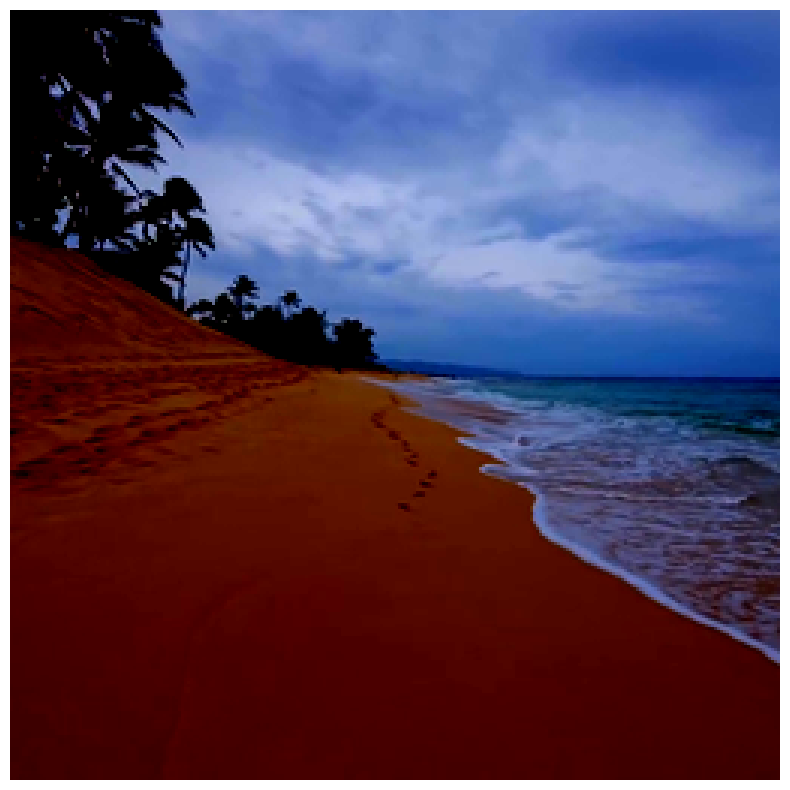

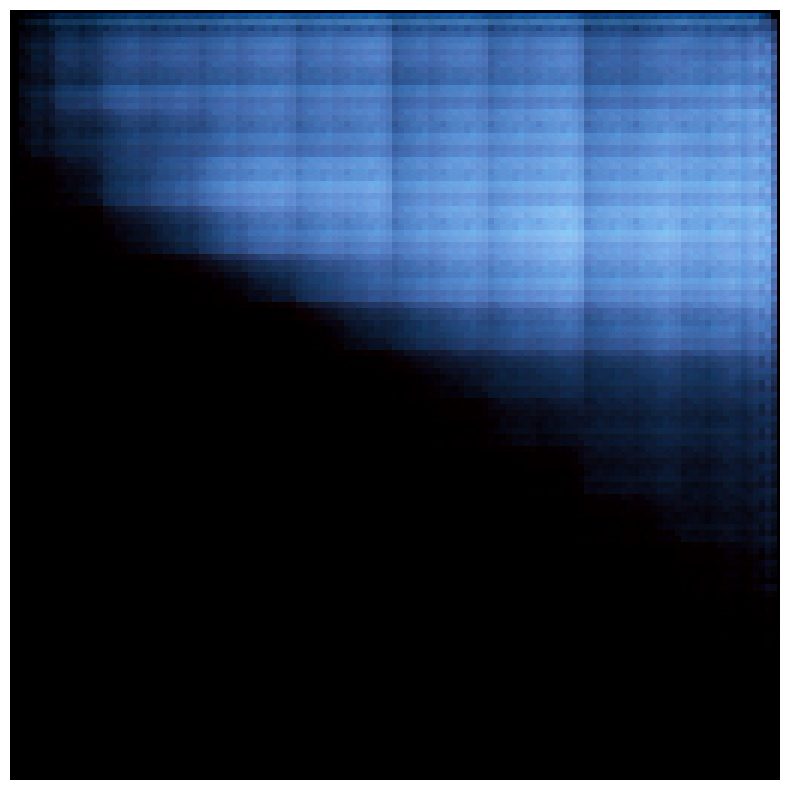

Epoch: 20, Training loss: 3.6921838521957397


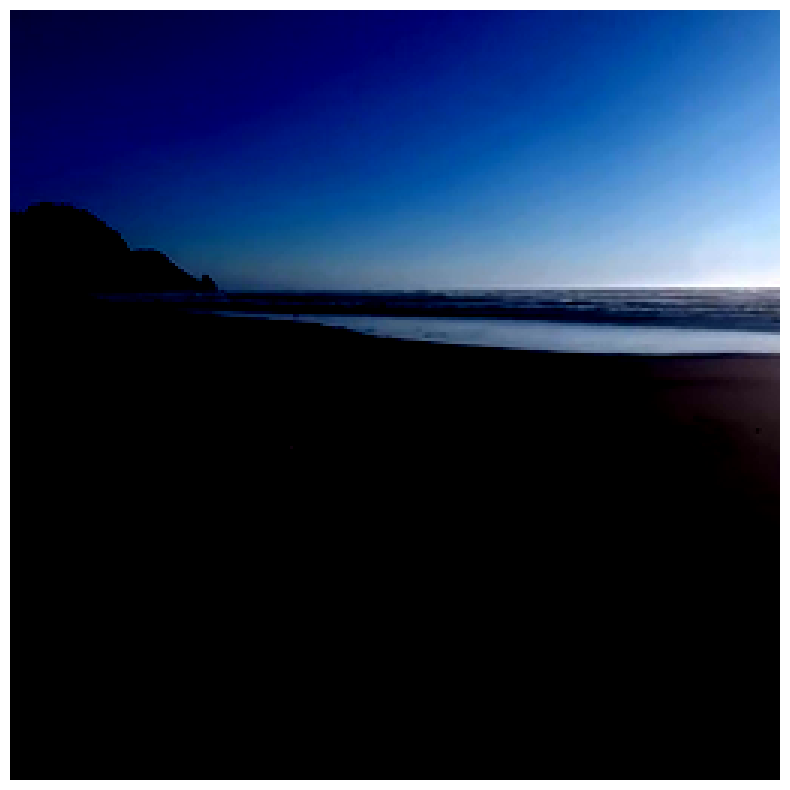

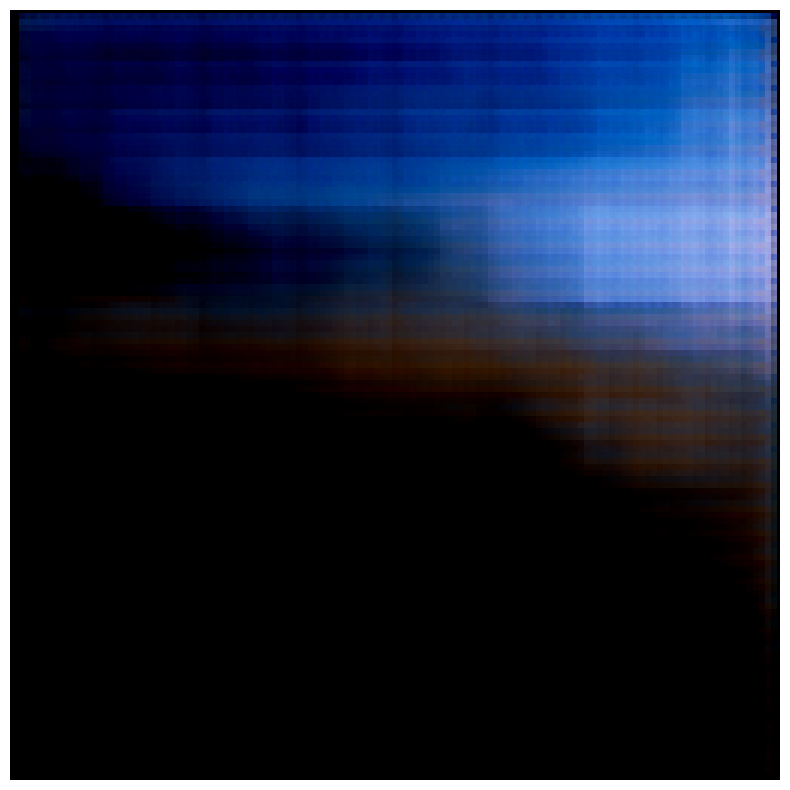

Epoch: 30, Training loss: 3.1522711515426636


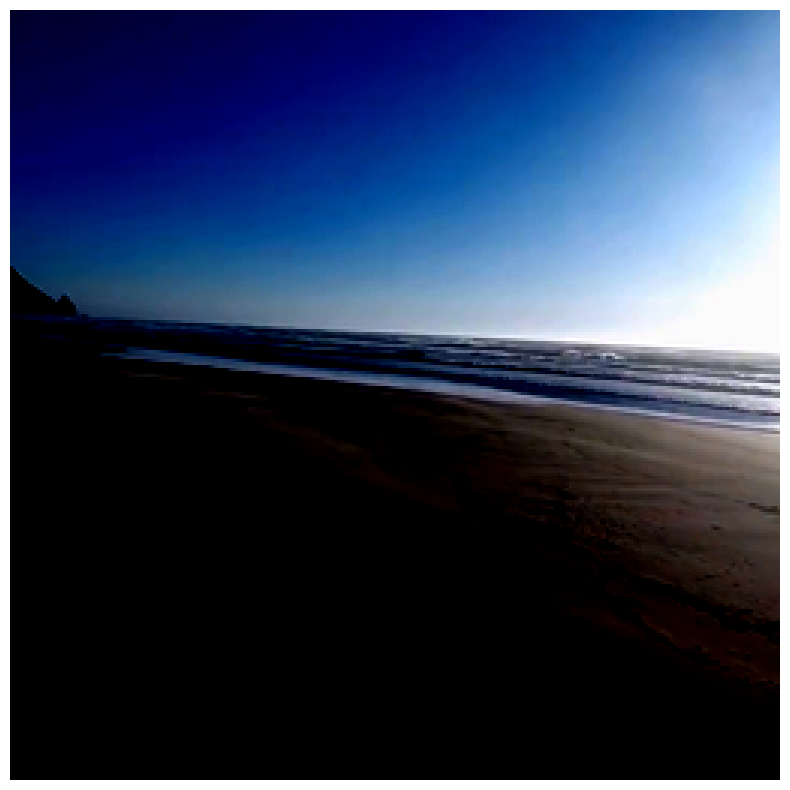

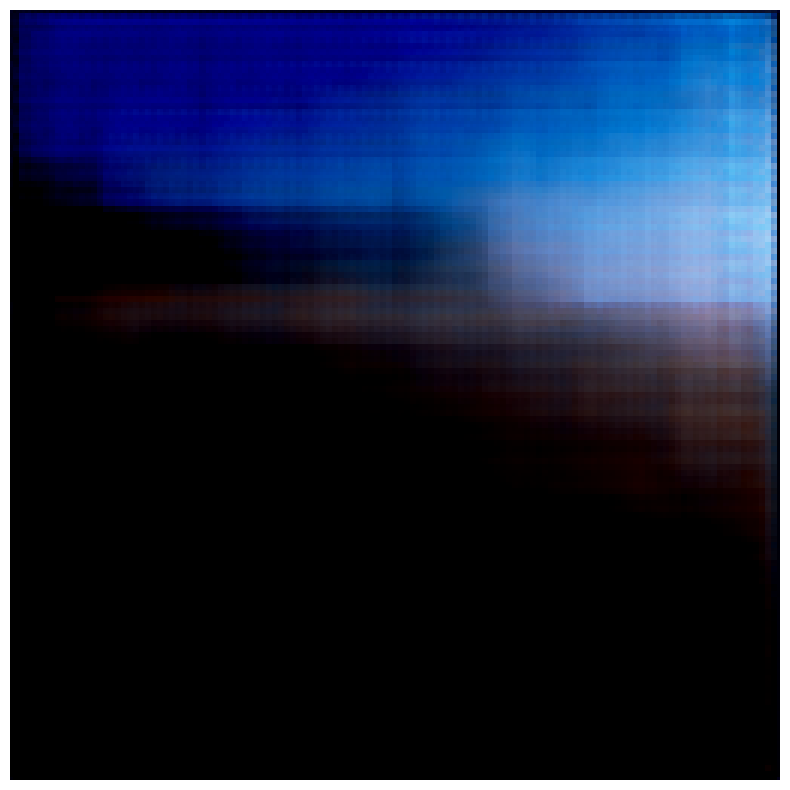

Epoch: 40, Training loss: 2.960493882497152


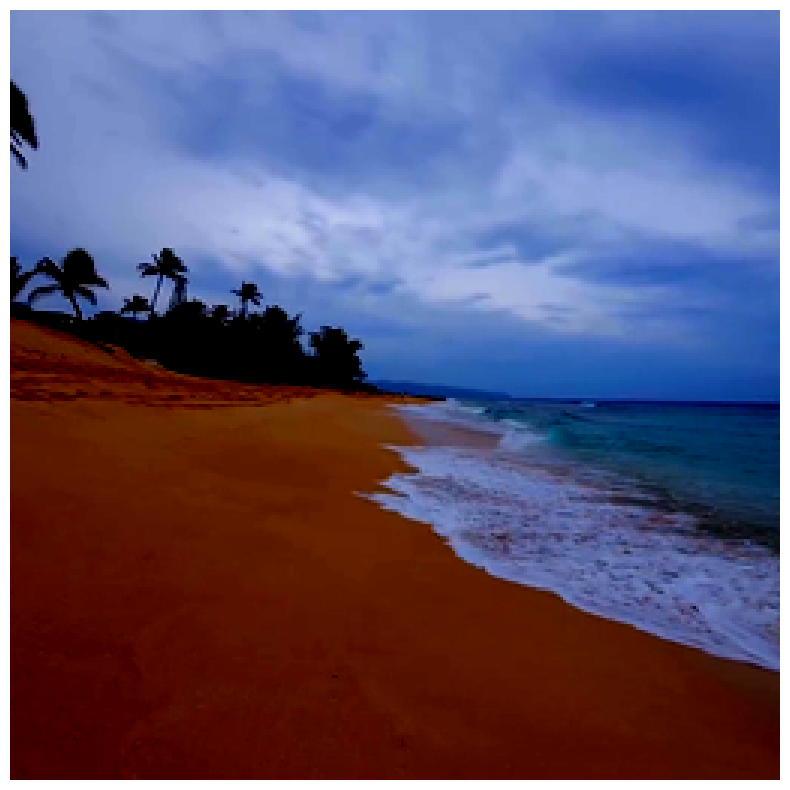

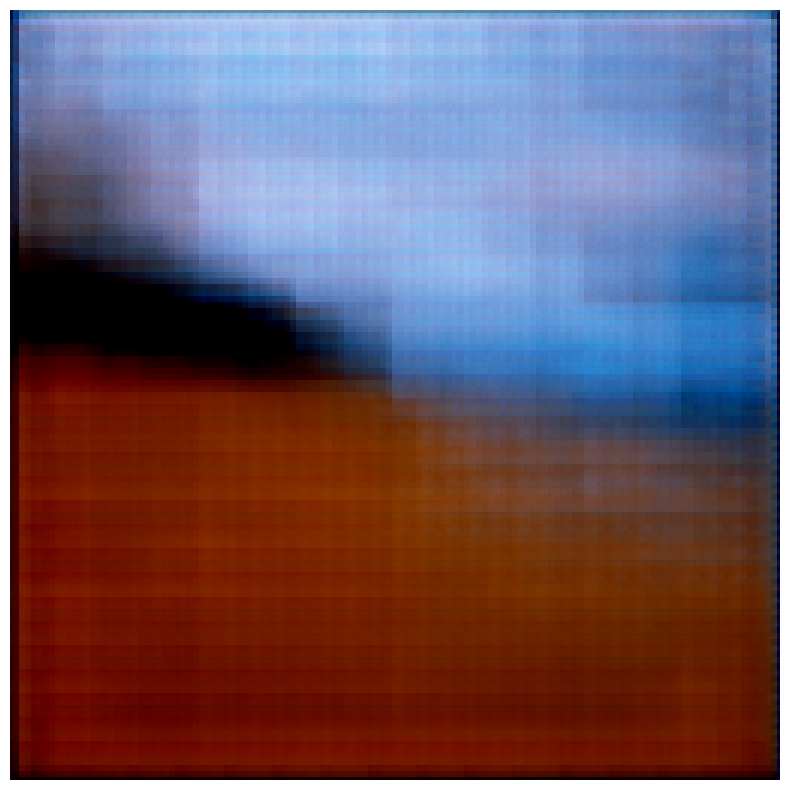

Epoch: 50, Training loss: 3.140787204106649


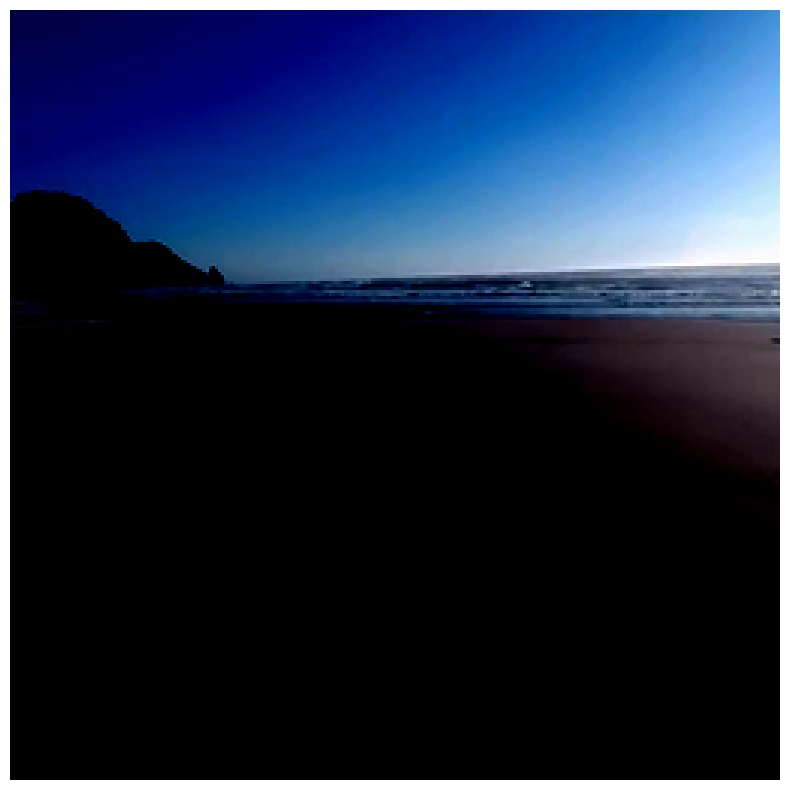

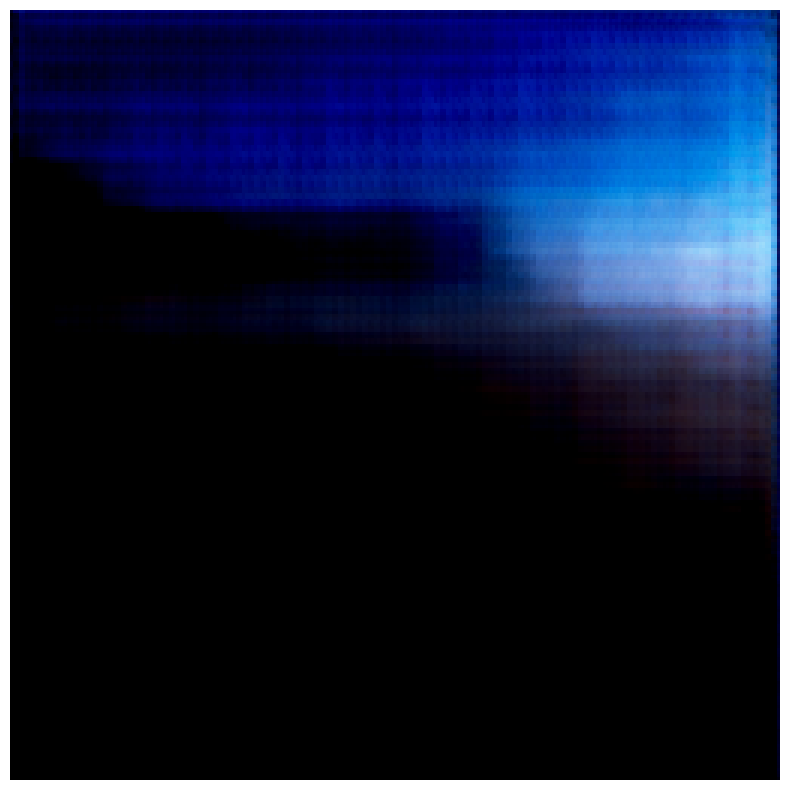

Epoch: 60, Training loss: 2.8229865630467734


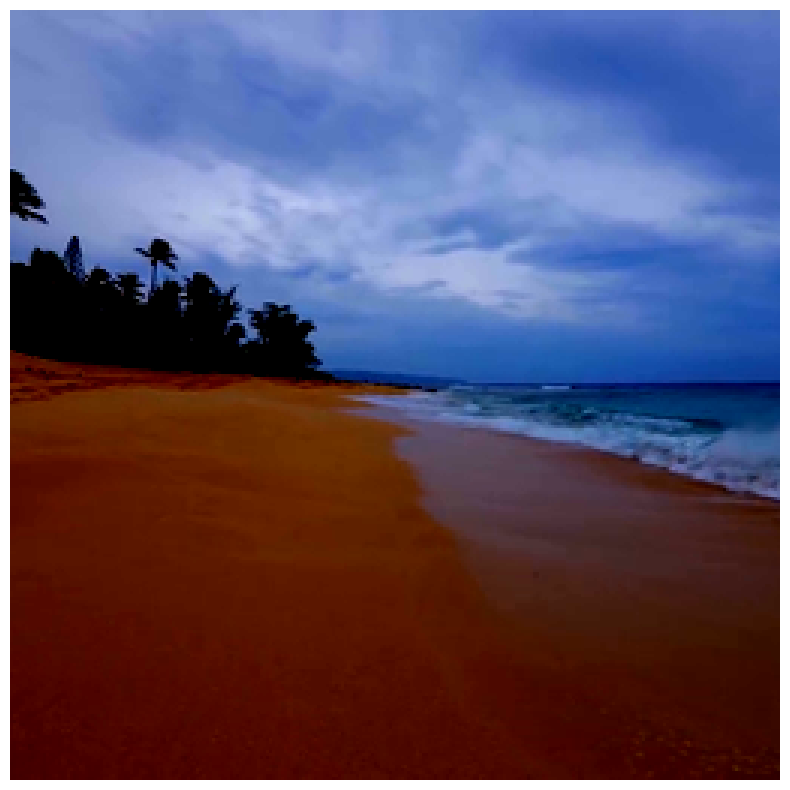

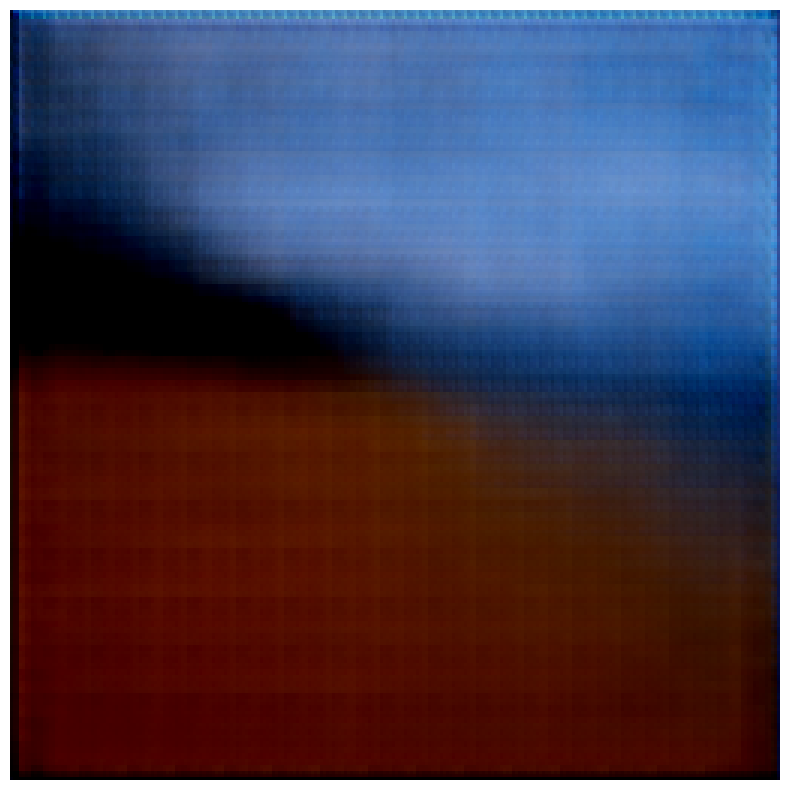

Epoch: 70, Training loss: 2.8116538524627686


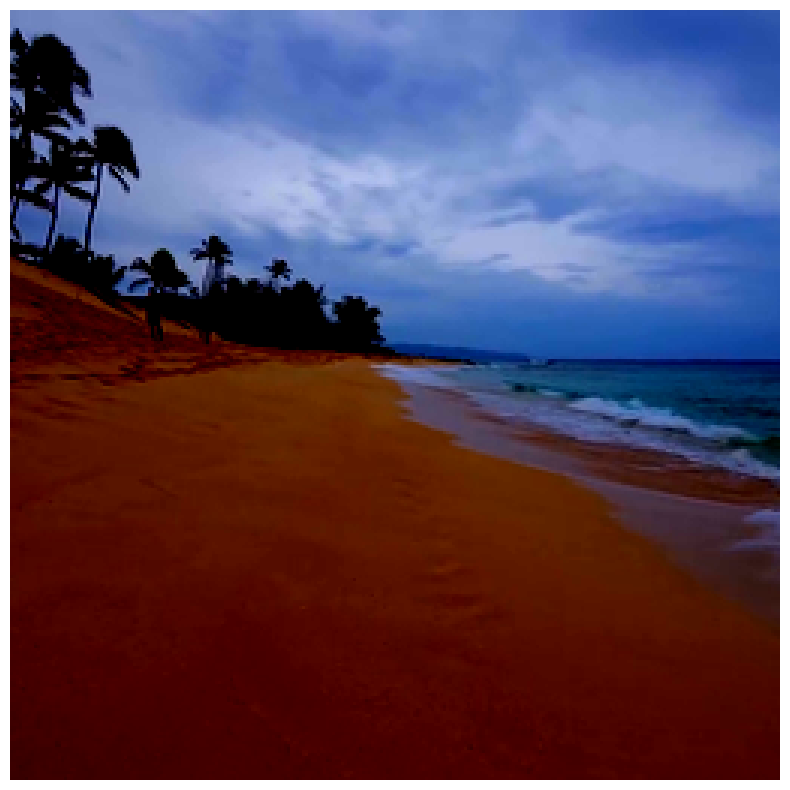

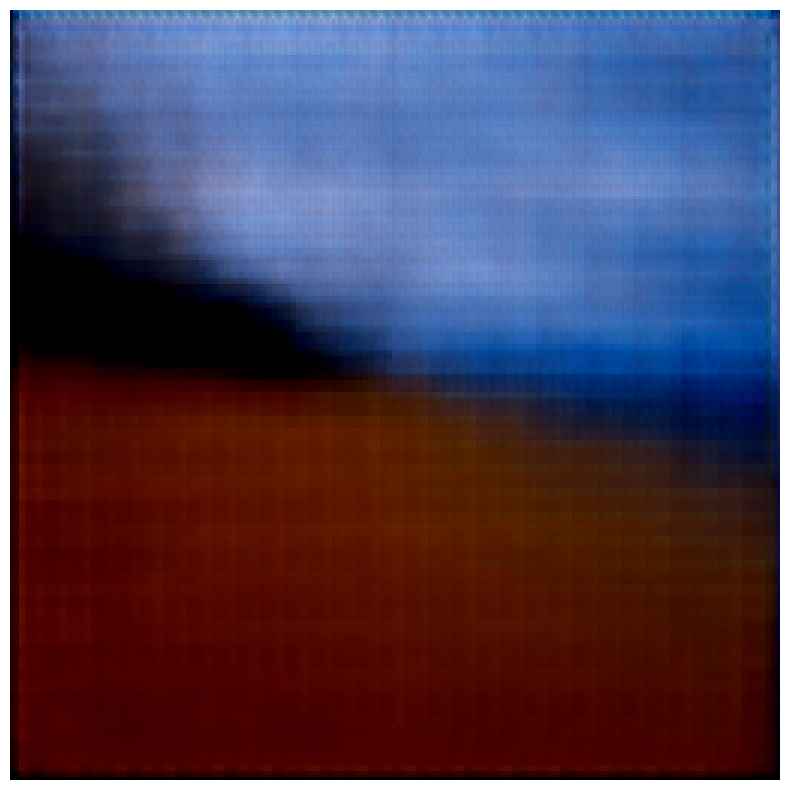

Epoch: 80, Training loss: 2.648524363835653


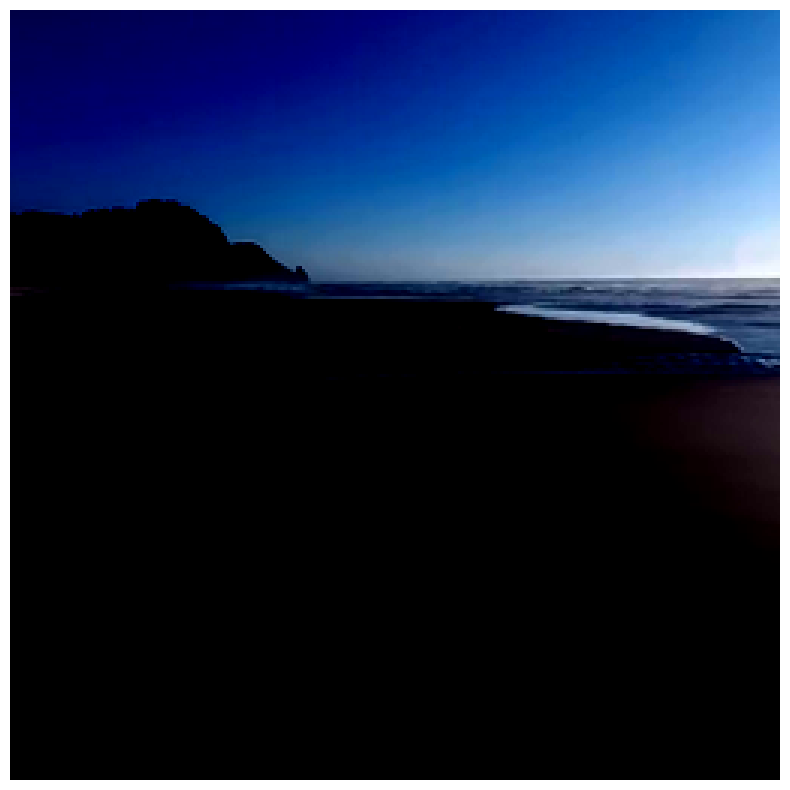

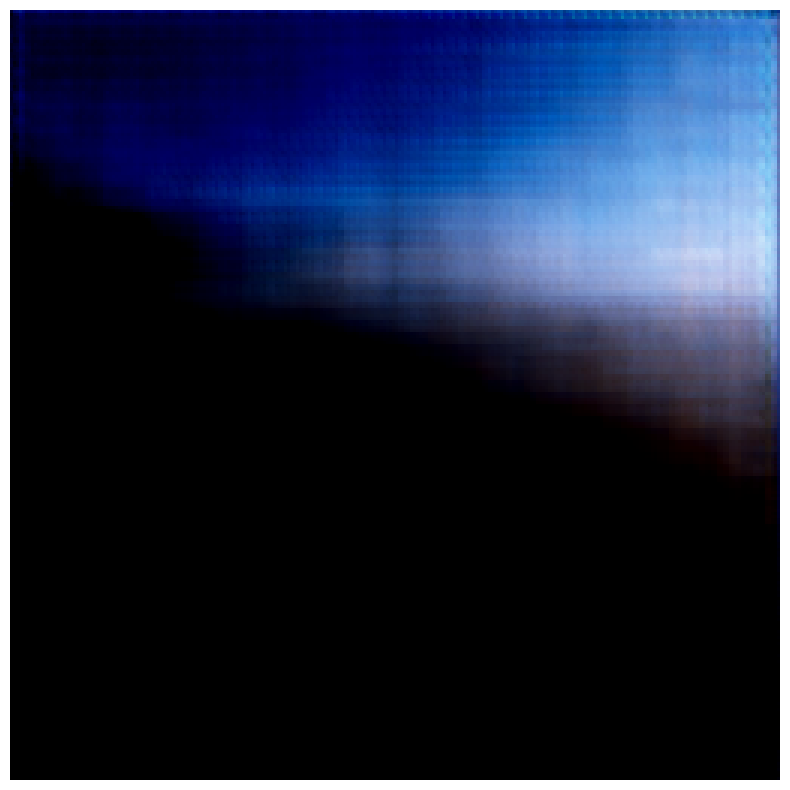

Epoch: 90, Training loss: 2.7595677773157754


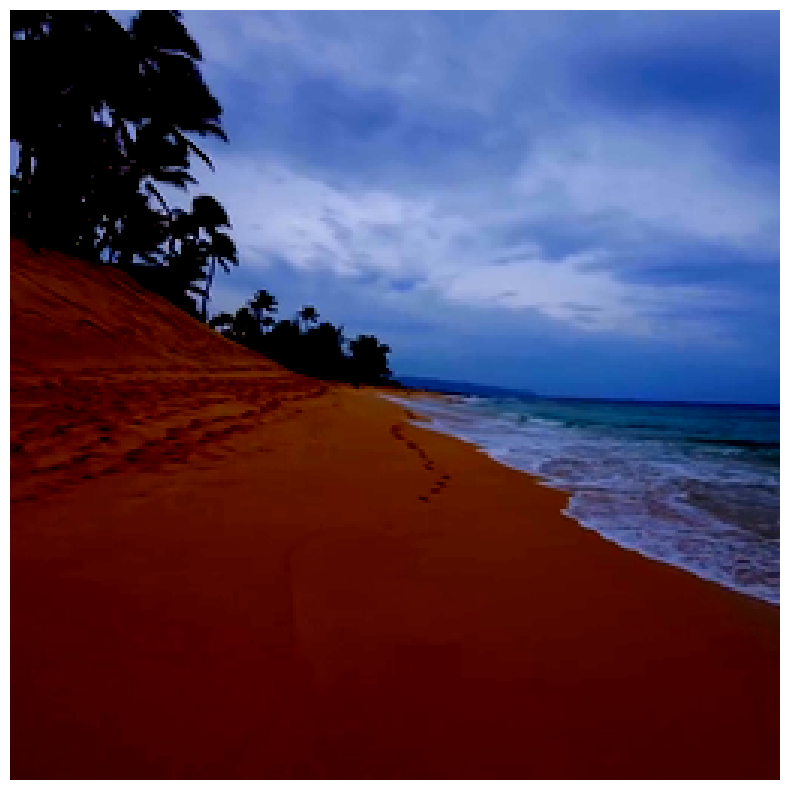

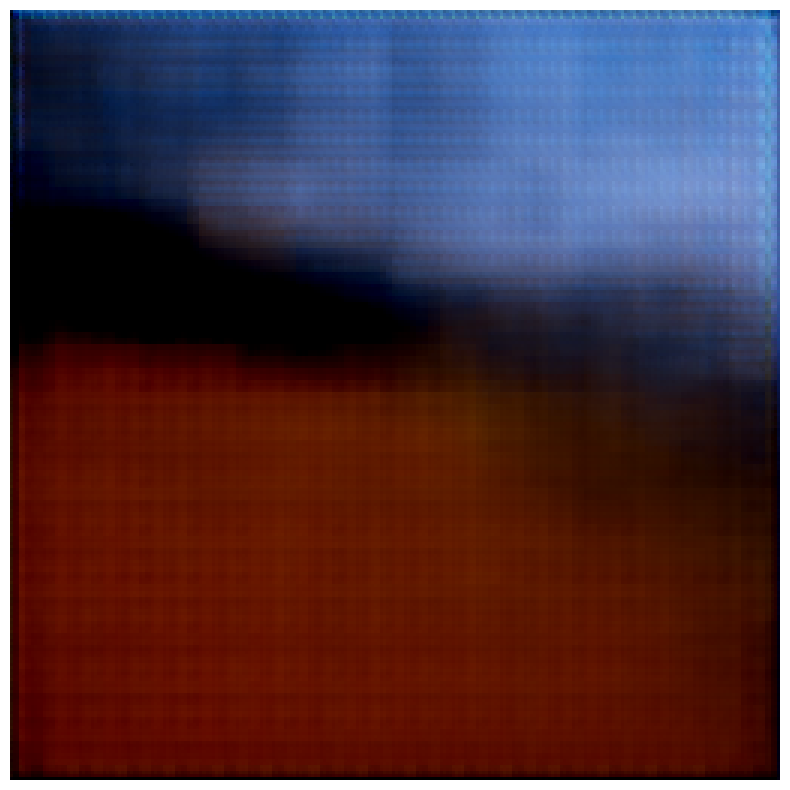

Epoch: 100, Training loss: 2.530473470687866


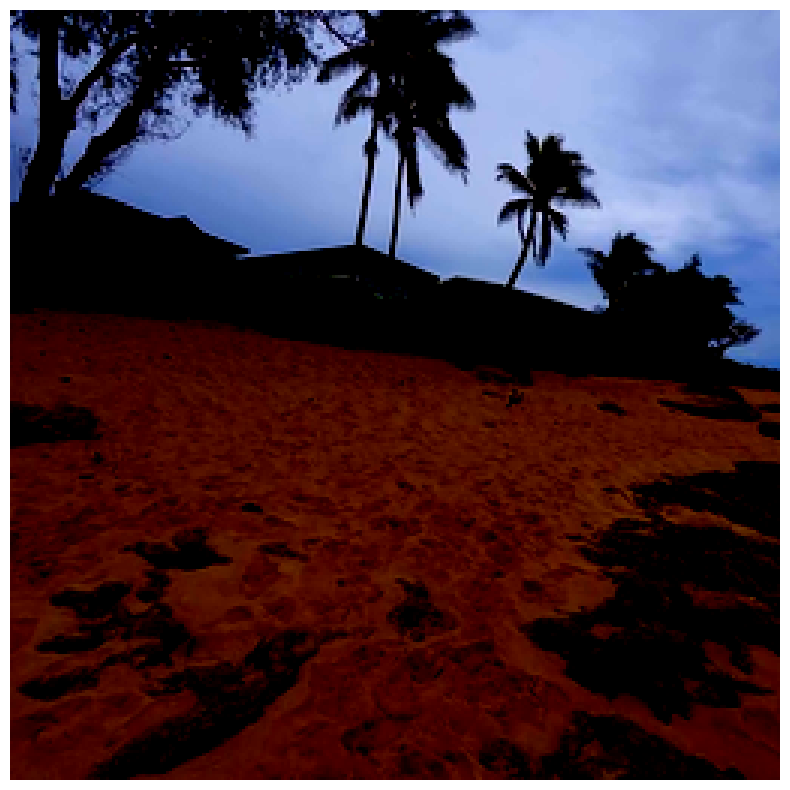

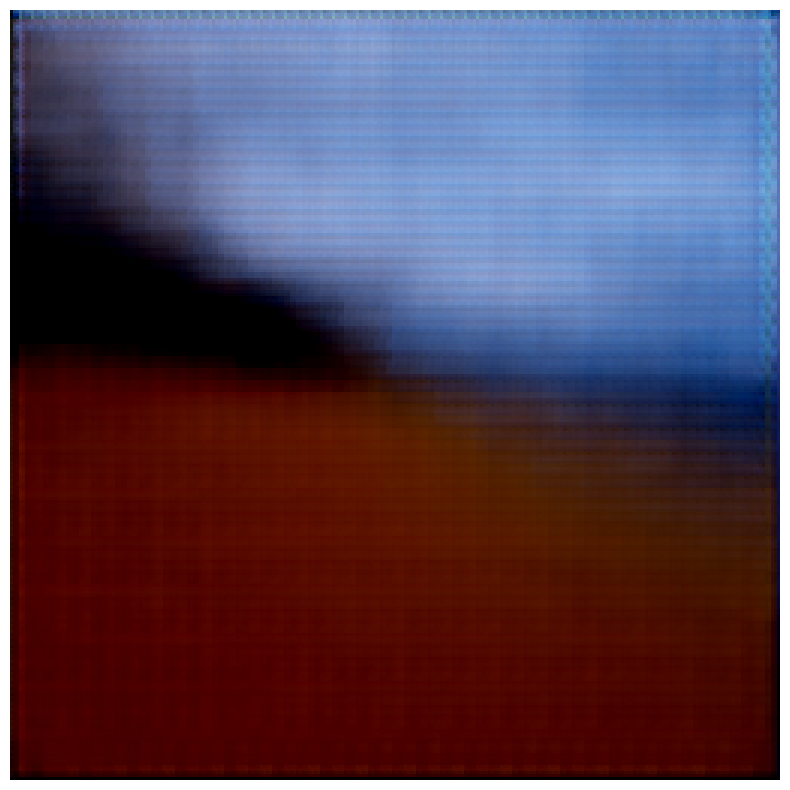

In [14]:
model.train()
losses = []

for epoch in range(epochs):
  train_loss = 0.0

  for data, target in train_dataloader:
    data = data.to(device)
    target = target.to(device)

    optimizer.zero_grad()

    output = model(data)
    loss = criterion(output, target)*batch_size

    #output, mu, logvar = model(data)

    #rep_loss = criterion(output, target, reduction='sum')
    #kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #loss = rep_loss + kld

    loss.backward()
    optimizer.step()

    #for param in model.parameters():
    #  print(param.grad)

    train_loss += loss.item()
  else:
    losses.append(train_loss/len(train_dataloader))

    if(epoch+1)%(epochs/10) == 0:
      print(f'Epoch: {epoch + 1}, Training loss: {train_loss/len(train_dataloader)}')
      plot_img(target.detach())
      plot_img(output.detach())

In [15]:
train_hist, train_ssim = calc_similarity(target.detach(), output.detach())
print(f'Average SSIM: {np.mean(train_ssim)}')
print(f'Average Hist: {np.mean(train_hist)}')

Average SSIM: 0.49499999999999994
Average Hist: 0.9982500000000002


Test loss: 4.239159107208252
Average SSIM: 0.46325000000000005
Average Hist: 0.9994999999999999


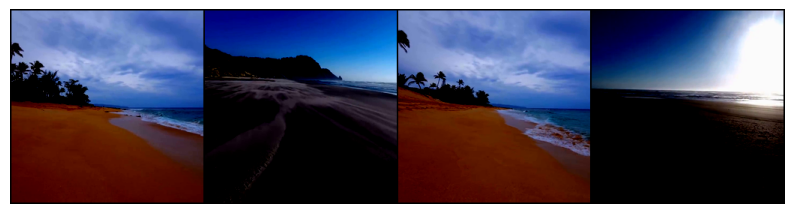

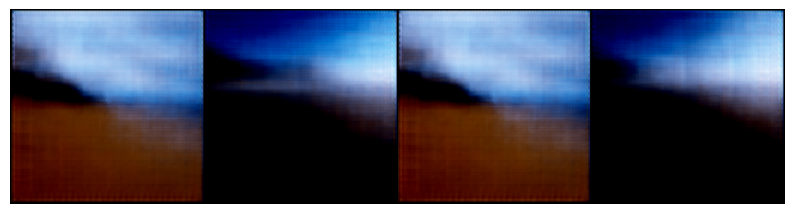

In [22]:
model.eval()
test_loss, avg_ssim, avg_hists = 0.0, 0.0, 0.0
hists, ssims = [], []

with torch.no_grad():
  for data, target in test_data_loader:
    data = data.to(device)
    target = target.to(device)

    predictions = model(data)

    loss = criterion(predictions, target)*batch_size
    test_loss += loss.item()

    hist, ssim = calc_similarity(target.detach(), predictions.detach())
    hists.extend(hist)
    ssims.extend(ssim)
  else:
    avg_ssim = np.mean(ssims)
    avg_hist = np.mean(hists)
    print(f'Test loss: {test_loss/len(test_data_loader)}')
    print(f'Average SSIM: {avg_ssim}')
    print(f'Average Hist: {avg_hist}')

    plot_imggrid(target.detach())
    plot_imggrid(predictions.detach())

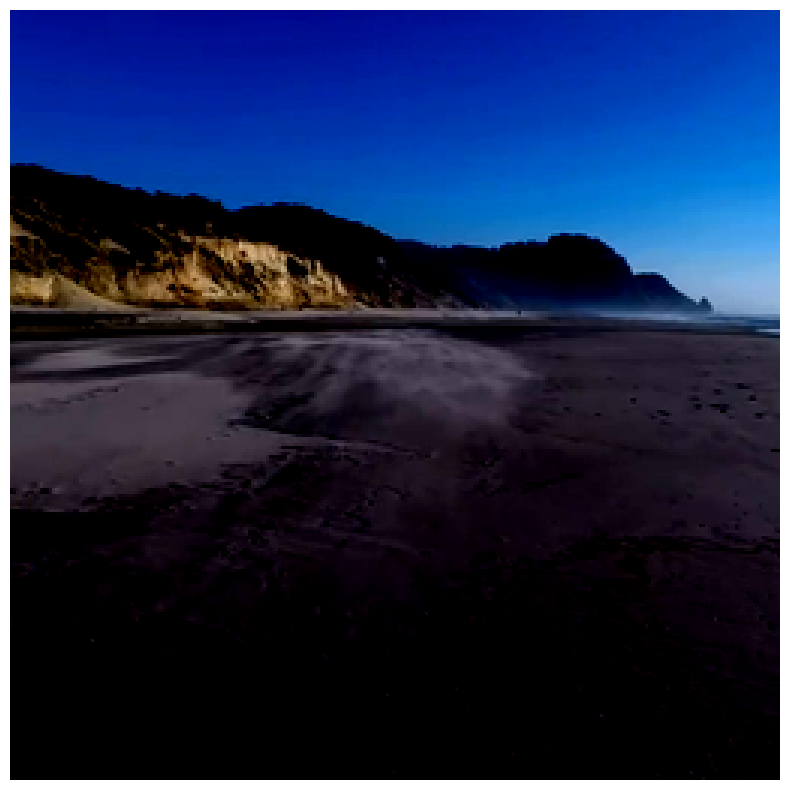

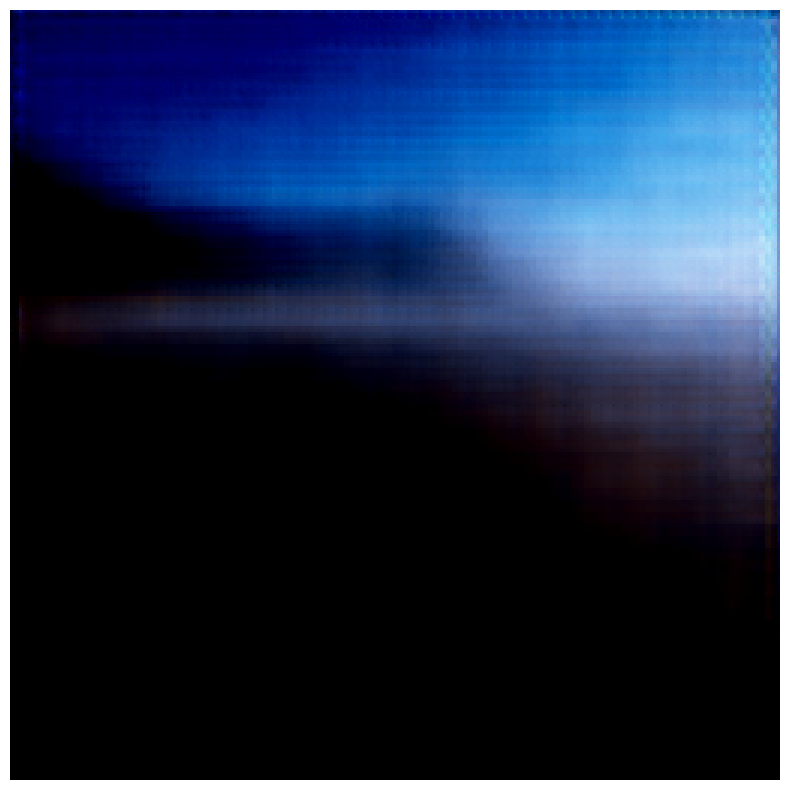

In [17]:
plot_img(target)
plot_img(predictions)